# Vision Transformer for Small Datasets (PyTorch Implementation)

**Description:**  
Train a Vision Transformer (ViT) from scratch on a small dataset using Shifted Patch Tokenization (SPT) and Locality Self-Attention (LSA) in PyTorch.

---

## Introduction

The [Vision Transformer (ViT)](https://arxiv.org/abs/2010.11929) architecture has set new benchmarks in image classification by applying Transformer models, originally developed for NLP, to visual data. However, ViT models typically require large-scale pretraining to outperform Convolutional Neural Networks (CNNs), because their self-attention mechanism lacks the **locality inductive bias** inherent to CNNs. This bias captures the spatial relationships between neighboring pixels, making CNNs more efficient on small or medium-sized datasets.

To address this limitation, the paper [Vision Transformer for Small-Size Datasets](https://arxiv.org/abs/2112.13492v1) introduces two key improvements:
- **Shifted Patch Tokenization (SPT):** Encourages the model to better capture local spatial features by generating patches from both original and shifted images.
- **Locality Self-Attention (LSA):** Modifies the attention mechanism to further embed local bias.

This notebook implements and experiments with these techniques in PyTorch, adapting the methodology from the official [Keras ViT small dataset example](https://keras.io/examples/vision/vit_small_ds/).  
We compare the impact of SPT and LSA (individually and combined) on CIFAR-100, and explore the effect of different data augmentation strategies.

---


## Setup

## Prepare the data

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
# Constants
NUM_CLASSES = 100
INPUT_SHAPE = (32, 32, 3)
BATCH_SIZE = 256

# Augmentation
IMAGE_SIZE = 72

# Use only Resize and ToTensor — no Normalize yet
transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])

# Load CIFAR-100
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

classes = train_dataset.classes

100%|██████████| 169M/169M [00:12<00:00, 13.3MB/s]


In [4]:
len(classes), classes[:2]

(100, ['apple', 'aquarium_fish'])

In [5]:
# train_dataset.data.shape  # → (50000, 32, 32, 3)
# comes as a NumPy array in N H W C format.
train_dataset.data.shape, test_dataset.data.shape

((50000, 32, 32, 3), (10000, 32, 32, 3))

In [6]:
# Create data loader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Let's have a look at the one batch to see
x_train, y_train = next(iter(train_loader))
x_test, y_test = next(iter(test_loader))

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}") # X_train shape = (B, C, W, H)
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: torch.Size([256, 3, 72, 72]) - y_train shape: torch.Size([256])
x_test shape: torch.Size([256, 3, 72, 72]) - y_test shape: torch.Size([256])


`ToTensor()` converts the image from PIL or NumPy (HWC) → PyTorch Tensor (CHW)

## Configure the hyperparameters

The hyperparameters are different from the paper. Feel free to tune
the hyperparameters yourself.

In [7]:
# =======================
# CONFIGURATION CONSTANTS
# =======================

# Data
BUFFER_SIZE = 512  # Not directly used in PyTorch (used in tf.data)
BATCH_SIZE = 256

# Augmentation
IMAGE_SIZE = 72
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2  # 12x12 = 144

# Optimizer
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001

# Training
EPOCHS = 50

# Architecture
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

NUM_CLASSES = 100
INPUT_SHAPE = (32, 32, 3)


## Use data augmentation

A snippet from the paper:

*"According to DeiT, various techniques are required to effectively
train ViTs. Thus, we applied data augmentations such as CutMix, Mixup,
Auto Augment, Repeated Augment to all models."*

In this example, we will focus solely on the novelty of the approach
and not on reproducing the paper results. For this reason, we
don't use the mentioned data augmentation schemes. Please feel
free to add to or remove from the augmentation pipeline.

In [8]:
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm



# Your efficient mean/std function
def get_mean_std(loader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
        num_batches += 1
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean**2) ** 0.5
    return mean, std



In [9]:
mean, std = get_mean_std(train_loader)
print(f"Mean: {mean}")
print(f"Std: {std}")

Mean: tensor([0.5073, 0.4867, 0.4411])
Std: tensor([0.2621, 0.2511, 0.2713])


In [10]:

# Convert mean/std tensors to lists
mean = mean.tolist()
std = std.tolist()

# Define the final transform for training
transform_train = transforms.Compose([
    transforms.Resize((72, 72)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.RandomRotation(degrees=2), # data augmentation technics
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)), # data augmentation technics
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Define the final transform for testing (no augmentation)
transform_test = transforms.Compose([
    transforms.Resize((72, 72)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

# Create the normalized datasets
train_dataset = datasets.CIFAR100(
    root='./data', train=True, download=False, transform=transform_train)

test_dataset = datasets.CIFAR100(
    root='./data', train=False, download=False, transform=transform_test)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


## Implement Shifted Patch Tokenization

In a ViT pipeline, the input images are divided into patches that are
then linearly projected into tokens. Shifted patch tokenization (STP)
is introduced to combat the low receptive field of ViTs. The steps
for Shifted Patch Tokenization are as follows:

- Start with an image.
- Shift the image in diagonal directions.
- Concat the diagonally shifted images with the original image.
- Extract patches of the concatenated images.
- Flatten the spatial dimension of all patches.
- Layer normalize the flattened patches and then project it.

| ![Shifted Patch Toekenization](https://i.imgur.com/bUnHxd0.png) |
| :--: |
| Shifted Patch Tokenization [Source](https://arxiv.org/abs/2112.13492v1) |

In [11]:
import torch
import torch.nn as nn

class SPT(nn.Module):
    def __init__(self, image_size=72, patch_size=6, projection_dim=64, vanilla=False, layer_norm_eps=1e-6):
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.vanilla = vanilla

        in_channels = 3 if vanilla else 15  # 5 x RGB
        patch_vector_dim = patch_size * patch_size * in_channels

        self.layer_norm = nn.LayerNorm(patch_vector_dim, eps=layer_norm_eps)
        self.projection = nn.Linear(patch_vector_dim, projection_dim)

    def crop_shift_pad(self, x, mode):
        """
        Applies the diagonal shift by cropping and zero-padding.
        Input x: (B, C, H, W)
        """
        B, C, H, W = x.shape
        shifted = torch.zeros_like(x)

        if mode == "left-up":
            shifted[:, :, :-self.half_patch, :-self.half_patch] = x[:, :, self.half_patch:, self.half_patch:]
        elif mode == "left-down":
            shifted[:, :, self.half_patch:, :-self.half_patch] = x[:, :, :-self.half_patch, self.half_patch:]
        elif mode == "right-up":
            shifted[:, :, :-self.half_patch, self.half_patch:] = x[:, :, self.half_patch:, :-self.half_patch]
        elif mode == "right-down":
            shifted[:, :, self.half_patch:, self.half_patch:] = x[:, :, :-self.half_patch, :-self.half_patch]

        return shifted

    def extract_patches(self, x):
        """
        Extract non-overlapping patches using nn.Unfold.
        Input: (B, C, H, W)
        Output: (B, num_patches, patch_vector_dim)
        """
        unfold = nn.Unfold(kernel_size=self.patch_size, stride=self.patch_size)
        patches = unfold(x)  # (B, patch_dim, num_patches)
        patches = patches.transpose(1, 2)  # (B, num_patches, patch_dim)
        return patches

    def forward(self, x):
        """
        Input: x (B, 3, 72, 72)
        Output:
            tokens: (B, 144, projection_dim)
            raw_patches: (B, 144, patch_vector_dim)
        """
        if not self.vanilla:
            shifts = [self.crop_shift_pad(x, mode) for mode in ["left-up", "left-down", "right-up", "right-down"]]
            x = torch.cat([x] + shifts, dim=1)  # (B, 15, 72, 72)

        patches = self.extract_patches(x)  # (B, 144, patch_vector_dim)

        if not self.vanilla:
            tokens = self.layer_norm(patches)
        else:
            tokens = patches
        tokens = self.projection(tokens)  # (B, 144, projection_dim)

        return tokens, patches


### Visualize the patches

In [12]:
# Pick a random image from the training loader
x_batch, _ = next(iter(train_loader))  # x_batch shape: (B, 3, 72, 72)
image = x_batch[random.randint(0, x_batch.shape[0] - 1)]  # (3, 72, 72)
print(f"Batch shape: {x_batch.shape}")
print(f"Image: {image.shape}")

Batch shape: torch.Size([256, 3, 72, 72])
Image: torch.Size([3, 72, 72])


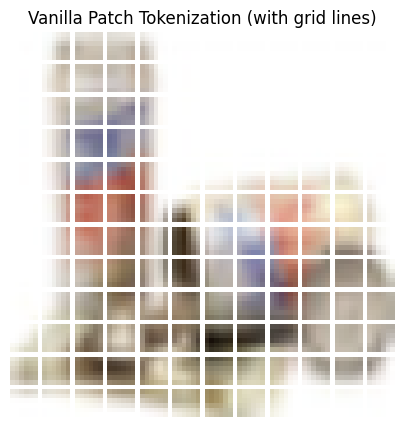

In [13]:
# Load unnormalized dataset
visual_transform = transforms.Compose([
    transforms.Resize((72, 72)),
    transforms.ToTensor()
])
visual_dataset = torchvision.datasets.CIFAR100(
    root='./data', train=True, download=False, transform=visual_transform
)

# Random image
idx = random.randint(0, len(visual_dataset) - 1)
image, label = visual_dataset[idx]  # image: (3, 72, 72)

# Tokenize into vanilla patches using SPT (PyTorch)
vanilla_tokenizer = SPT(vanilla=True)
_, patch = vanilla_tokenizer(image.unsqueeze(0))  # patch: (1, 144, 540)
patch = patch[0]  # (144, 540)

# Reshape patch: from (144, 540) to (144, 3, 6, 6)
patch = patch.reshape(144, 3, 6, 6)

# Permute to (144, 6, 6, 3) for matplotlib
patch = patch.permute(0, 2, 3, 1)

# Build full grid with 1-pixel white lines
n = 12
H, W = 6, 6
gap = 1
grid_h = n * H + (n - 1) * gap
grid_w = n * W + (n - 1) * gap
grid = np.ones((grid_h, grid_w, 3), dtype=np.float32)  # white background

# Fill in patches
count = 0
for row in range(n):
    for col in range(n):
        y = row * (H + gap)
        x = col * (W + gap)
        grid[y:y+H, x:x+W, :] = patch[count].numpy()
        count += 1

# Display
plt.figure(figsize=(5, 5))
plt.imshow(grid)
plt.axis("off")
plt.title("Vanilla Patch Tokenization (with grid lines)")
plt.show()


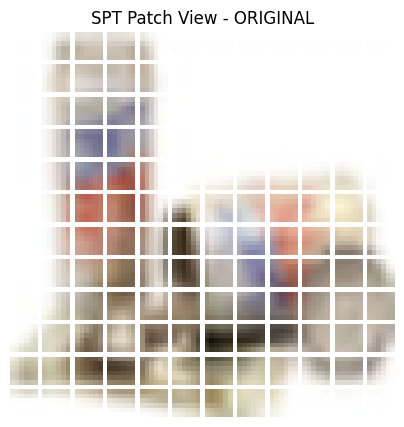

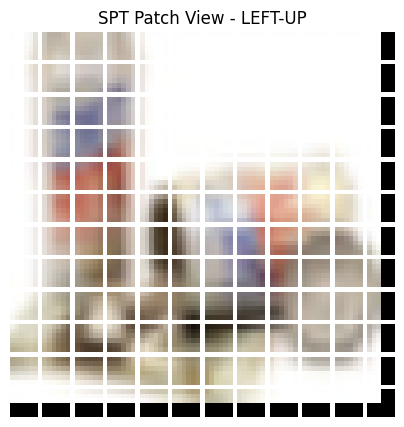

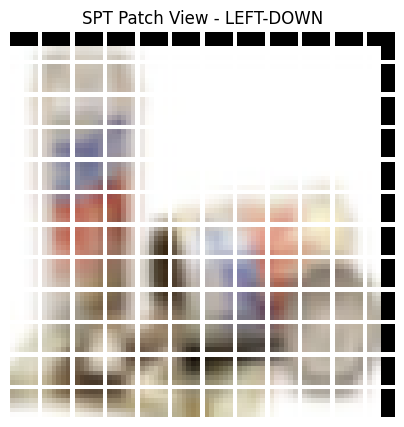

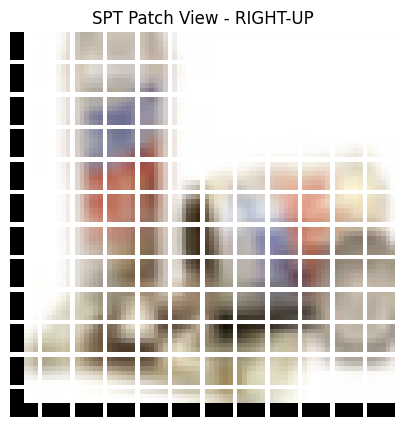

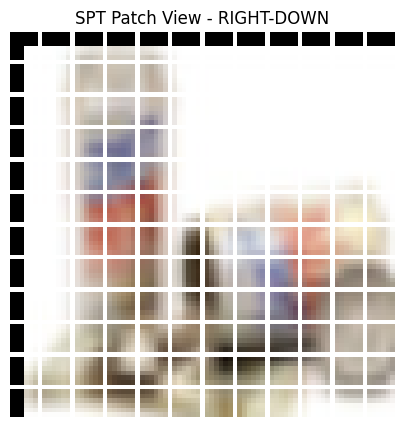

In [14]:
# Tokenize with SPT (with shifts)
spt_tokenizer = SPT(vanilla=False)
_, patch = spt_tokenizer(image.unsqueeze(0))  # (1, 144, 540)
patch = patch[0]  # (144, 540)

# Reshape to (144, 15, 6, 6) → 15 = 5 shifts × 3 channels
patch = patch.reshape(144, 15, 6, 6)

# Reshape to (144, 5, 3, 6, 6) → (patches, shifts, C, H, W)
patch = patch.reshape(144, 5, 3, 6, 6)

# Permute to (patches, shifts, H, W, C)
patch = patch.permute(0, 1, 3, 4, 2)

# Plot each shifted view
shifted_images = ["ORIGINAL", "LEFT-UP", "LEFT-DOWN", "RIGHT-UP", "RIGHT-DOWN"]
n = 12
H, W = 6, 6
gap = 1
grid_h = n * H + (n - 1) * gap
grid_w = n * W + (n - 1) * gap

for shift_index, shift_name in enumerate(shifted_images):
    # Build white background grid
    grid = np.ones((grid_h, grid_w, 3), dtype=np.float32)

    count = 0
    for row in range(n):
        for col in range(n):
            y = row * (H + gap)
            x = col * (W + gap)
            grid[y:y+H, x:x+W, :] = patch[count, shift_index].numpy()
            count += 1

    # Display
    plt.figure(figsize=(5, 5))
    plt.imshow(grid)
    plt.title(f"SPT Patch View - {shift_name}")
    plt.axis("off")
    plt.show()


## Implement the patch encoding layer

This layer accepts projected patches and then adds positional
information to them.

In [15]:
import torch
import torch.nn as nn

class PatchEncoder(nn.Module):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.position_embedding = nn.Embedding(num_patches, projection_dim)

    def forward(self, encoded_patches):
        """
        encoded_patches: (B, num_patches, projection_dim)
        """
        positions = torch.arange(self.num_patches, device=encoded_patches.device)  # (num_patches,)
        encoded_positions = self.position_embedding(positions)                      # (num_patches, projection_dim)
        return encoded_patches + encoded_positions                                 # broadcasted over batch



## Implement Locality Self Attention

The regular attention equation is stated below.

| ![Equation of attention](https://miro.medium.com/max/396/1*P9sV1xXM10t943bXy_G9yg.png) |
| :--: |
| [Source](https://towardsdatascience.com/attention-is-all-you-need-discovering-the-transformer-paper-73e5ff5e0634) |

The attention module takes a query, key, and value. First, we compute the
similarity between the query and key via a dot product. Then, the result
is scaled by the square root of the key dimension. The scaling prevents
the softmax function from having an overly small gradient. Softmax is then
applied to the scaled dot product to produce the attention weights.
The value is then modulated via the attention weights.

In self-attention, query, key and value come from the same input.
The dot product would result in large self-token relations rather than
inter-token relations. This also means that the softmax gives higher
probabilities to self-token relations than the inter-token relations.
To combat this, the authors propose masking the diagonal of the dot product.
This way, we force the attention module to pay more attention to the
inter-token relations.

The scaling factor is a constant in the regular attention module.
This acts like a temperature term that can modulate the softmax function.
The authors suggest a learnable temperature term instead of a constant.

| ![Implementation of LSA](https://i.imgur.com/GTV99pk.png) |
| :--: |
| Locality Self Attention [Source](https://arxiv.org/abs/2112.13492v1) |

The above two pointers make the Locality Self Attention. We have subclassed the
[`layers.MultiHeadAttention`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MultiHeadAttention)
and implemented the trainable temperature. The attention mask is built
at a later stage.

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MultiHeadAttentionLSA(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        assert (
            self.head_dim * num_heads == embed_dim
        ), "embed_dim must be divisible by num_heads"

        # Learnable temperature parameter (per attention head)
        self.tau = nn.Parameter(torch.full((1, num_heads, 1, 1), math.sqrt(self.head_dim)))

        self.q_proj = nn.Linear(embed_dim, embed_dim)
        self.k_proj = nn.Linear(embed_dim, embed_dim)
        self.v_proj = nn.Linear(embed_dim, embed_dim)
        self.out_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, key, value, mask=None):
        # query/key/value: (B, N, D)
        B, N, D = query.shape

        # Linear projections
        q = self.q_proj(query).reshape(B, N, self.num_heads, self.head_dim).transpose(1, 2)  # (B, num_heads, N, head_dim)
        k = self.k_proj(key).reshape(B, N, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(value).reshape(B, N, self.num_heads, self.head_dim).transpose(1, 2)

        # LSA: scale by learnable tau
        q = q / self.tau  # (B, num_heads, N, head_dim)

        # Attention scores
        attn_scores = torch.matmul(q, k.transpose(-2, -1))  # (B, num_heads, N, N)

        if mask is not None:
            mask.to(device)
            attn_scores = attn_scores.masked_fill(mask == 0, float('-inf'))

        attn_probs = F.softmax(attn_scores, dim=-1)
        attn_probs = self.dropout(attn_probs)

        attn_output = torch.matmul(attn_probs, v)  # (B, num_heads, N, head_dim)

        # Concatenate heads
        attn_output = attn_output.transpose(1, 2).reshape(B, N, D)
        return self.out_proj(attn_output), attn_probs  # (B, N, D), (B, num_heads, N, N)


## Implement the MLP

In [17]:

class MLP(nn.Module):
    def __init__(self, input_dim, hidden_units, dropout_rate):
        super().__init__()
        layers = []
        for units in hidden_units:
            layers.append(nn.Linear(input_dim, units))
            layers.append(nn.GELU())
            layers.append(nn.Dropout(dropout_rate))
            input_dim = units
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)



# Build the diagonal attention mask
diag_attn_mask = 1 - torch.eye(NUM_PATCHES)
diag_attn_mask = diag_attn_mask.unsqueeze(0).to(dtype=torch.int8)  # shape (1, NUM_PATCHES, NUM_PATCHES)
diag_attn_mask.to(device)

tensor([[[0, 1, 1,  ..., 1, 1, 1],
         [1, 0, 1,  ..., 1, 1, 1],
         [1, 1, 0,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 0, 1, 1],
         [1, 1, 1,  ..., 1, 0, 1],
         [1, 1, 1,  ..., 1, 1, 0]]], device='cuda:0', dtype=torch.int8)

## Build the ViT

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ViTClassifier(nn.Module):
    def __init__(
        self,
        image_size=IMAGE_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        num_heads=NUM_HEADS,
        transformer_layers=TRANSFORMER_LAYERS,
        transformer_units=TRANSFORMER_UNITS,
        mlp_head_units=MLP_HEAD_UNITS,
        num_classes=NUM_CLASSES,
        dropout_rate=0.1,
        vanilla=False,
        diag_attn_mask=None
    ):
        super().__init__()
        self.vanilla = vanilla
        self.data_augmentation = nn.Identity()  # (the data augmentation was included in the initialization of the dataset creation)
        self.spt = SPT(
            image_size=image_size,
            patch_size=patch_size,
            projection_dim=projection_dim,
            vanilla=vanilla
        )
        self.patch_encoder = PatchEncoder(num_patches, projection_dim)

        # Transformer blocks
        self.transformer_blocks = nn.ModuleList()
        for _ in range(transformer_layers):
            block = nn.ModuleDict({
                'norm1': nn.LayerNorm(projection_dim, eps=1e-6),
                'mha': MultiHeadAttentionLSA(
                    embed_dim=projection_dim,
                    num_heads=num_heads,
                    dropout=dropout_rate
                ) if not vanilla else nn.MultiheadAttention(
                    embed_dim=projection_dim,
                    num_heads=num_heads,
                    dropout=dropout_rate,
                    batch_first=True
                ),
                'norm2': nn.LayerNorm(projection_dim, eps=1e-6),
                'mlp': MLP(projection_dim, transformer_units, dropout_rate)
            })
            self.transformer_blocks.append(block)

        self.final_norm = nn.LayerNorm(projection_dim, eps=1e-6)
        self.flatten = nn.Flatten()
        self.final_dropout = nn.Dropout(0.5)
        self.mlp_head = MLP(num_patches * projection_dim, mlp_head_units, dropout_rate=0.5)
        self.classifier = nn.Linear(mlp_head_units[-1], num_classes)

        # Mask
        self.diag_attn_mask = diag_attn_mask if diag_attn_mask is not None else None

    def forward(self, x):
        # x: (B, 3, H, W)
        x = self.data_augmentation(x)  # (optional, can use outside the model)
        tokens, _ = self.spt(x)  # (B, num_patches, projection_dim)
        x = self.patch_encoder(tokens)  # (B, num_patches, projection_dim)

        for block in self.transformer_blocks:
            # LayerNorm 1
            x1 = block['norm1'](x)
            # Attention
            if not self.vanilla:
                # LSA (mask: (1, num_patches, num_patches))
                attn_mask = self.diag_attn_mask.to(device)
                attn_out, _ = block['mha'](x1, x1, x1, mask=attn_mask)
            else:
                attn_out, _ = block['mha'](x1, x1, x1)
            # Residual 1
            x2 = x + attn_out
            # LayerNorm 2
            x3 = block['norm2'](x2)
            # MLP
            x3 = block['mlp'](x3)
            # Residual 2
            x = x2 + x3

        # Final norm and flatten
        x = self.final_norm(x)
        x = self.flatten(x)
        x = self.final_dropout(x)
        x = self.mlp_head(x)
        logits = self.classifier(x)
        return logits


## Compile, train, and evaluate the mode

In [19]:
import math
from torch.optim.lr_scheduler import LambdaLR

def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, base_lr):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))
        return 0.5 * (1.0 + math.cos(math.pi * progress))
    return LambdaLR(optimizer, lr_lambda)


In [20]:
!pip install torchmetrics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 111.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.1 MB/s eta 0:00:00


In [21]:
import torch
from torch.utils.data import random_split, DataLoader
from torch.optim import AdamW
from torchmetrics.classification import MulticlassAccuracy

def run_experiment(model, train_dataset, test_dataset, device):
    # Prepare train/val split
    val_fraction = 0.1
    val_size = int(len(train_dataset) * val_fraction)
    train_size = len(train_dataset) - val_size
    train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    model = model.to(device)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

    # Scheduler
    total_steps = EPOCHS * len(train_loader)
    warmup_steps = int(total_steps * 0.1)
    scheduler = get_cosine_schedule_with_warmup(optimizer, warmup_steps, total_steps, LEARNING_RATE)

    # Loss and metrics
    criterion = torch.nn.CrossEntropyLoss()
    acc_metric = MulticlassAccuracy(num_classes=NUM_CLASSES, top_k=1).to(device)
    acc5_metric = MulticlassAccuracy(num_classes=NUM_CLASSES, top_k=5).to(device)

    for epoch in tqdm(range(EPOCHS)):
        model.train()
        train_loss = 0.0
        for step, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()
            scheduler.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_acc = 0.0
        val_acc5 = 0.0
        count = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                val_acc += acc_metric(logits, y).item() * x.size(0)
                val_acc5 += acc5_metric(logits, y).item() * x.size(0)
                count += x.size(0)
        print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {train_loss/len(train_loader):.4f} | "
              f"Val Acc: {val_acc/count:.4f} | Val Top-5 Acc: {val_acc5/count:.4f}")

    # Test set
    model.eval()
    test_acc = 0.0
    test_acc5 = 0.0
    count = 0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            test_acc += acc_metric(logits, y).item() * x.size(0)
            test_acc5 += acc5_metric(logits, y).item() * x.size(0)
            count += x.size(0)
    print(f"Test accuracy: {test_acc/count*100:.2f}%")
    print(f"Test top 5 accuracy: {test_acc5/count*100:.2f}%")

    return model


In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train Vanilla ViT
vit = ViTClassifier(vanilla=True)
run_experiment(vit, train_dataset, test_dataset, device)



  2%|▏         | 1/50 [00:46<37:56, 46.45s/it]

Epoch 1/50 | Loss: 4.3737 | Val Acc: 0.1039 | Val Top-5 Acc: 0.3140


  4%|▍         | 2/50 [01:26<34:14, 42.80s/it]

Epoch 2/50 | Loss: 3.8940 | Val Acc: 0.1565 | Val Top-5 Acc: 0.4101


  6%|▌         | 3/50 [02:08<33:05, 42.24s/it]

Epoch 3/50 | Loss: 3.6522 | Val Acc: 0.1906 | Val Top-5 Acc: 0.4712


  8%|▊         | 4/50 [02:48<31:42, 41.35s/it]

Epoch 4/50 | Loss: 3.4878 | Val Acc: 0.2071 | Val Top-5 Acc: 0.5089


 10%|█         | 5/50 [03:27<30:34, 40.77s/it]

Epoch 5/50 | Loss: 3.3988 | Val Acc: 0.2294 | Val Top-5 Acc: 0.5319


 12%|█▏        | 6/50 [04:07<29:38, 40.43s/it]

Epoch 6/50 | Loss: 3.3295 | Val Acc: 0.2401 | Val Top-5 Acc: 0.5575


 14%|█▍        | 7/50 [04:47<28:53, 40.31s/it]

Epoch 7/50 | Loss: 3.2201 | Val Acc: 0.2614 | Val Top-5 Acc: 0.5791


 16%|█▌        | 8/50 [05:28<28:11, 40.27s/it]

Epoch 8/50 | Loss: 3.0980 | Val Acc: 0.2686 | Val Top-5 Acc: 0.5804


 18%|█▊        | 9/50 [06:07<27:25, 40.15s/it]

Epoch 9/50 | Loss: 3.0023 | Val Acc: 0.2873 | Val Top-5 Acc: 0.6099


 20%|██        | 10/50 [06:49<26:58, 40.46s/it]

Epoch 10/50 | Loss: 2.8861 | Val Acc: 0.3096 | Val Top-5 Acc: 0.6203


 22%|██▏       | 11/50 [07:28<26:10, 40.26s/it]

Epoch 11/50 | Loss: 2.8017 | Val Acc: 0.3096 | Val Top-5 Acc: 0.6407


 24%|██▍       | 12/50 [08:08<25:26, 40.16s/it]

Epoch 12/50 | Loss: 2.7208 | Val Acc: 0.3312 | Val Top-5 Acc: 0.6512


 26%|██▌       | 13/50 [08:48<24:41, 40.03s/it]

Epoch 13/50 | Loss: 2.6425 | Val Acc: 0.3316 | Val Top-5 Acc: 0.6510


 28%|██▊       | 14/50 [09:28<23:55, 39.88s/it]

Epoch 14/50 | Loss: 2.5742 | Val Acc: 0.3477 | Val Top-5 Acc: 0.6705


 30%|███       | 15/50 [10:07<23:15, 39.87s/it]

Epoch 15/50 | Loss: 2.5081 | Val Acc: 0.3455 | Val Top-5 Acc: 0.6708


 32%|███▏      | 16/50 [10:48<22:40, 40.00s/it]

Epoch 16/50 | Loss: 2.4547 | Val Acc: 0.3625 | Val Top-5 Acc: 0.6796


 34%|███▍      | 17/50 [11:28<22:03, 40.10s/it]

Epoch 17/50 | Loss: 2.3801 | Val Acc: 0.3681 | Val Top-5 Acc: 0.6865


 36%|███▌      | 18/50 [12:09<21:27, 40.23s/it]

Epoch 18/50 | Loss: 2.3106 | Val Acc: 0.3756 | Val Top-5 Acc: 0.6905


 38%|███▊      | 19/50 [12:48<20:43, 40.11s/it]

Epoch 19/50 | Loss: 2.2597 | Val Acc: 0.3813 | Val Top-5 Acc: 0.6955


 40%|████      | 20/50 [13:28<20:01, 40.07s/it]

Epoch 20/50 | Loss: 2.2120 | Val Acc: 0.3770 | Val Top-5 Acc: 0.7000


 42%|████▏     | 21/50 [14:08<19:20, 40.02s/it]

Epoch 21/50 | Loss: 2.1522 | Val Acc: 0.3888 | Val Top-5 Acc: 0.7042


 44%|████▍     | 22/50 [14:48<18:40, 40.00s/it]

Epoch 22/50 | Loss: 2.0987 | Val Acc: 0.3903 | Val Top-5 Acc: 0.7087


 46%|████▌     | 23/50 [15:28<18:01, 40.07s/it]

Epoch 23/50 | Loss: 2.0294 | Val Acc: 0.3934 | Val Top-5 Acc: 0.7056


 48%|████▊     | 24/50 [16:08<17:20, 40.04s/it]

Epoch 24/50 | Loss: 1.9740 | Val Acc: 0.4035 | Val Top-5 Acc: 0.7185


 50%|█████     | 25/50 [16:49<16:46, 40.26s/it]

Epoch 25/50 | Loss: 1.9299 | Val Acc: 0.3943 | Val Top-5 Acc: 0.7132


 52%|█████▏    | 26/50 [17:29<16:03, 40.14s/it]

Epoch 26/50 | Loss: 1.8741 | Val Acc: 0.4032 | Val Top-5 Acc: 0.7221


 54%|█████▍    | 27/50 [18:08<15:16, 39.83s/it]

Epoch 27/50 | Loss: 1.8143 | Val Acc: 0.4054 | Val Top-5 Acc: 0.7188


 56%|█████▌    | 28/50 [18:48<14:36, 39.84s/it]

Epoch 28/50 | Loss: 1.7598 | Val Acc: 0.4059 | Val Top-5 Acc: 0.7301


 58%|█████▊    | 29/50 [19:28<13:58, 39.93s/it]

Epoch 29/50 | Loss: 1.7082 | Val Acc: 0.4167 | Val Top-5 Acc: 0.7241


 60%|██████    | 30/50 [20:08<13:18, 39.94s/it]

Epoch 30/50 | Loss: 1.6740 | Val Acc: 0.4181 | Val Top-5 Acc: 0.7309


 62%|██████▏   | 31/50 [20:48<12:39, 39.95s/it]

Epoch 31/50 | Loss: 1.6238 | Val Acc: 0.4126 | Val Top-5 Acc: 0.7344


 64%|██████▍   | 32/50 [21:29<12:02, 40.16s/it]

Epoch 32/50 | Loss: 1.5782 | Val Acc: 0.4183 | Val Top-5 Acc: 0.7259


 66%|██████▌   | 33/50 [22:10<11:27, 40.46s/it]

Epoch 33/50 | Loss: 1.5434 | Val Acc: 0.4251 | Val Top-5 Acc: 0.7295


 68%|██████▊   | 34/50 [22:50<10:44, 40.29s/it]

Epoch 34/50 | Loss: 1.5052 | Val Acc: 0.4198 | Val Top-5 Acc: 0.7366


 70%|███████   | 35/50 [23:30<10:02, 40.14s/it]

Epoch 35/50 | Loss: 1.4603 | Val Acc: 0.4250 | Val Top-5 Acc: 0.7424


 72%|███████▏  | 36/50 [24:09<09:20, 40.03s/it]

Epoch 36/50 | Loss: 1.4344 | Val Acc: 0.4283 | Val Top-5 Acc: 0.7363


 74%|███████▍  | 37/50 [24:49<08:39, 40.00s/it]

Epoch 37/50 | Loss: 1.3987 | Val Acc: 0.4268 | Val Top-5 Acc: 0.7314


 76%|███████▌  | 38/50 [25:30<08:00, 40.06s/it]

Epoch 38/50 | Loss: 1.3746 | Val Acc: 0.4326 | Val Top-5 Acc: 0.7421


 78%|███████▊  | 39/50 [26:09<07:20, 40.03s/it]

Epoch 39/50 | Loss: 1.3454 | Val Acc: 0.4322 | Val Top-5 Acc: 0.7362


 80%|████████  | 40/50 [26:50<06:42, 40.26s/it]

Epoch 40/50 | Loss: 1.3292 | Val Acc: 0.4245 | Val Top-5 Acc: 0.7449


 82%|████████▏ | 41/50 [27:31<06:02, 40.26s/it]

Epoch 41/50 | Loss: 1.3105 | Val Acc: 0.4337 | Val Top-5 Acc: 0.7433


 84%|████████▍ | 42/50 [28:10<05:20, 40.02s/it]

Epoch 42/50 | Loss: 1.2842 | Val Acc: 0.4342 | Val Top-5 Acc: 0.7384


 86%|████████▌ | 43/50 [28:50<04:39, 39.91s/it]

Epoch 43/50 | Loss: 1.2760 | Val Acc: 0.4388 | Val Top-5 Acc: 0.7460


 88%|████████▊ | 44/50 [29:29<03:59, 39.86s/it]

Epoch 44/50 | Loss: 1.2634 | Val Acc: 0.4371 | Val Top-5 Acc: 0.7430


 90%|█████████ | 45/50 [30:09<03:19, 39.88s/it]

Epoch 45/50 | Loss: 1.2583 | Val Acc: 0.4359 | Val Top-5 Acc: 0.7434


 92%|█████████▏| 46/50 [30:49<02:39, 39.85s/it]

Epoch 46/50 | Loss: 1.2464 | Val Acc: 0.4406 | Val Top-5 Acc: 0.7416


 94%|█████████▍| 47/50 [31:29<01:59, 39.78s/it]

Epoch 47/50 | Loss: 1.2404 | Val Acc: 0.4363 | Val Top-5 Acc: 0.7451


 96%|█████████▌| 48/50 [32:10<01:20, 40.17s/it]

Epoch 48/50 | Loss: 1.2353 | Val Acc: 0.4325 | Val Top-5 Acc: 0.7452


 98%|█████████▊| 49/50 [32:50<00:40, 40.20s/it]

Epoch 49/50 | Loss: 1.2333 | Val Acc: 0.4347 | Val Top-5 Acc: 0.7403


100%|██████████| 50/50 [33:29<00:00, 40.20s/it]

Epoch 50/50 | Loss: 1.2334 | Val Acc: 0.4369 | Val Top-5 Acc: 0.7424


Test accuracy: 43.06%
Test top 5 accuracy: 73.57%


ViTClassifier(
  (data_augmentation): Identity()
  (spt): SPT(
    (layer_norm): LayerNorm((108,), eps=1e-06, elementwise_affine=True)
    (projection): Linear(in_features=108, out_features=64, bias=True)
  )
  (patch_encoder): PatchEncoder(
    (position_embedding): Embedding(144, 64)
  )
  (transformer_blocks): ModuleList(
    (0-7): 8 x ModuleDict(
      (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
      )
      (norm2): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (mlp): Sequential(
          (0): Linear(in_features=64, out_features=128, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=128, out_features=64, bias=True)
          (4): GELU(approximate='none')
          (5): Dropout(p=0.1, inplace=False)
        )
      )
    )


In [23]:
# Train SPT+LSA ViT
vit_sl = ViTClassifier(vanilla=False, diag_attn_mask=diag_attn_mask)
run_experiment(vit_sl, train_dataset, test_dataset, device)


  2%|▏         | 1/50 [00:44<36:43, 44.98s/it]

Epoch 1/50 | Loss: 4.4000 | Val Acc: 0.1084 | Val Top-5 Acc: 0.2964


  4%|▍         | 2/50 [01:28<35:21, 44.19s/it]

Epoch 2/50 | Loss: 3.8629 | Val Acc: 0.1651 | Val Top-5 Acc: 0.4180


  6%|▌         | 3/50 [02:13<34:50, 44.48s/it]

Epoch 3/50 | Loss: 3.6201 | Val Acc: 0.1934 | Val Top-5 Acc: 0.4539


  8%|▊         | 4/50 [02:57<33:58, 44.32s/it]

Epoch 4/50 | Loss: 3.4668 | Val Acc: 0.2052 | Val Top-5 Acc: 0.4863


 10%|█         | 5/50 [03:42<33:20, 44.46s/it]

Epoch 5/50 | Loss: 3.3732 | Val Acc: 0.2254 | Val Top-5 Acc: 0.5233


 12%|█▏        | 6/50 [04:26<32:31, 44.36s/it]

Epoch 6/50 | Loss: 3.3003 | Val Acc: 0.2344 | Val Top-5 Acc: 0.5355


 14%|█▍        | 7/50 [05:11<32:03, 44.73s/it]

Epoch 7/50 | Loss: 3.1666 | Val Acc: 0.2506 | Val Top-5 Acc: 0.5715


 16%|█▌        | 8/50 [05:56<31:12, 44.59s/it]

Epoch 8/50 | Loss: 3.0339 | Val Acc: 0.2796 | Val Top-5 Acc: 0.5830


 18%|█▊        | 9/50 [06:40<30:23, 44.47s/it]

Epoch 9/50 | Loss: 2.9067 | Val Acc: 0.2951 | Val Top-5 Acc: 0.6183


 20%|██        | 10/50 [07:24<29:39, 44.50s/it]

Epoch 10/50 | Loss: 2.7624 | Val Acc: 0.3189 | Val Top-5 Acc: 0.6332


 22%|██▏       | 11/50 [08:09<28:54, 44.48s/it]

Epoch 11/50 | Loss: 2.6358 | Val Acc: 0.3291 | Val Top-5 Acc: 0.6374


 24%|██▍       | 12/50 [08:54<28:13, 44.57s/it]

Epoch 12/50 | Loss: 2.5190 | Val Acc: 0.3451 | Val Top-5 Acc: 0.6753


 26%|██▌       | 13/50 [09:38<27:30, 44.60s/it]

Epoch 13/50 | Loss: 2.4284 | Val Acc: 0.3706 | Val Top-5 Acc: 0.6874


 28%|██▊       | 14/50 [10:23<26:45, 44.61s/it]

Epoch 14/50 | Loss: 2.3374 | Val Acc: 0.3670 | Val Top-5 Acc: 0.6880


 30%|███       | 15/50 [11:07<25:57, 44.50s/it]

Epoch 15/50 | Loss: 2.2542 | Val Acc: 0.3842 | Val Top-5 Acc: 0.7047


 32%|███▏      | 16/50 [11:52<25:19, 44.68s/it]

Epoch 16/50 | Loss: 2.1906 | Val Acc: 0.3945 | Val Top-5 Acc: 0.7149


 34%|███▍      | 17/50 [12:37<24:31, 44.59s/it]

Epoch 17/50 | Loss: 2.1058 | Val Acc: 0.4120 | Val Top-5 Acc: 0.7277


 36%|███▌      | 18/50 [13:21<23:48, 44.63s/it]

Epoch 18/50 | Loss: 2.0373 | Val Acc: 0.4058 | Val Top-5 Acc: 0.7331


 38%|███▊      | 19/50 [14:06<23:00, 44.54s/it]

Epoch 19/50 | Loss: 1.9698 | Val Acc: 0.4112 | Val Top-5 Acc: 0.7383


 40%|████      | 20/50 [14:50<22:16, 44.54s/it]

Epoch 20/50 | Loss: 1.9158 | Val Acc: 0.4210 | Val Top-5 Acc: 0.7381


 42%|████▏     | 21/50 [15:34<21:26, 44.36s/it]

Epoch 21/50 | Loss: 1.8587 | Val Acc: 0.4343 | Val Top-5 Acc: 0.7473


 44%|████▍     | 22/50 [16:19<20:47, 44.54s/it]

Epoch 22/50 | Loss: 1.8024 | Val Acc: 0.4286 | Val Top-5 Acc: 0.7494


 46%|████▌     | 23/50 [17:04<20:01, 44.49s/it]

Epoch 23/50 | Loss: 1.7399 | Val Acc: 0.4346 | Val Top-5 Acc: 0.7569


 48%|████▊     | 24/50 [17:49<19:21, 44.68s/it]

Epoch 24/50 | Loss: 1.6844 | Val Acc: 0.4395 | Val Top-5 Acc: 0.7566


 50%|█████     | 25/50 [18:33<18:34, 44.56s/it]

Epoch 25/50 | Loss: 1.6405 | Val Acc: 0.4442 | Val Top-5 Acc: 0.7552


 52%|█████▏    | 26/50 [19:18<17:51, 44.66s/it]

Epoch 26/50 | Loss: 1.5817 | Val Acc: 0.4417 | Val Top-5 Acc: 0.7675


 54%|█████▍    | 27/50 [20:02<17:02, 44.46s/it]

Epoch 27/50 | Loss: 1.5499 | Val Acc: 0.4569 | Val Top-5 Acc: 0.7695


 56%|█████▌    | 28/50 [20:47<16:23, 44.72s/it]

Epoch 28/50 | Loss: 1.4937 | Val Acc: 0.4531 | Val Top-5 Acc: 0.7681


 58%|█████▊    | 29/50 [21:31<15:35, 44.53s/it]

Epoch 29/50 | Loss: 1.4523 | Val Acc: 0.4606 | Val Top-5 Acc: 0.7669


 60%|██████    | 30/50 [22:16<14:53, 44.69s/it]

Epoch 30/50 | Loss: 1.4036 | Val Acc: 0.4656 | Val Top-5 Acc: 0.7794


 62%|██████▏   | 31/50 [23:00<14:05, 44.47s/it]

Epoch 31/50 | Loss: 1.3643 | Val Acc: 0.4614 | Val Top-5 Acc: 0.7779


 64%|██████▍   | 32/50 [23:45<13:23, 44.63s/it]

Epoch 32/50 | Loss: 1.3280 | Val Acc: 0.4560 | Val Top-5 Acc: 0.7714


 66%|██████▌   | 33/50 [24:29<12:36, 44.49s/it]

Epoch 33/50 | Loss: 1.2827 | Val Acc: 0.4627 | Val Top-5 Acc: 0.7731


 68%|██████▊   | 34/50 [25:14<11:50, 44.43s/it]

Epoch 34/50 | Loss: 1.2566 | Val Acc: 0.4693 | Val Top-5 Acc: 0.7787


 70%|███████   | 35/50 [25:58<11:05, 44.38s/it]

Epoch 35/50 | Loss: 1.2251 | Val Acc: 0.4695 | Val Top-5 Acc: 0.7786


 72%|███████▏  | 36/50 [26:43<10:21, 44.43s/it]

Epoch 36/50 | Loss: 1.1988 | Val Acc: 0.4806 | Val Top-5 Acc: 0.7815


 74%|███████▍  | 37/50 [27:27<09:37, 44.46s/it]

Epoch 37/50 | Loss: 1.1804 | Val Acc: 0.4732 | Val Top-5 Acc: 0.7805


 76%|███████▌  | 38/50 [28:11<08:52, 44.35s/it]

Epoch 38/50 | Loss: 1.1613 | Val Acc: 0.4771 | Val Top-5 Acc: 0.7826


 78%|███████▊  | 39/50 [28:56<08:10, 44.55s/it]

Epoch 39/50 | Loss: 1.1320 | Val Acc: 0.4769 | Val Top-5 Acc: 0.7853


 80%|████████  | 40/50 [29:40<07:23, 44.40s/it]

Epoch 40/50 | Loss: 1.1133 | Val Acc: 0.4770 | Val Top-5 Acc: 0.7825


 82%|████████▏ | 41/50 [30:25<06:41, 44.56s/it]

Epoch 41/50 | Loss: 1.0939 | Val Acc: 0.4770 | Val Top-5 Acc: 0.7870


 84%|████████▍ | 42/50 [31:09<05:55, 44.49s/it]

Epoch 42/50 | Loss: 1.0851 | Val Acc: 0.4879 | Val Top-5 Acc: 0.7917


 86%|████████▌ | 43/50 [31:54<05:12, 44.63s/it]

Epoch 43/50 | Loss: 1.0786 | Val Acc: 0.4894 | Val Top-5 Acc: 0.7889


 88%|████████▊ | 44/50 [32:38<04:26, 44.41s/it]

Epoch 44/50 | Loss: 1.0592 | Val Acc: 0.4790 | Val Top-5 Acc: 0.7874


 90%|█████████ | 45/50 [33:23<03:42, 44.49s/it]

Epoch 45/50 | Loss: 1.0587 | Val Acc: 0.4751 | Val Top-5 Acc: 0.7900


 92%|█████████▏| 46/50 [34:07<02:57, 44.40s/it]

Epoch 46/50 | Loss: 1.0426 | Val Acc: 0.4830 | Val Top-5 Acc: 0.7888


 94%|█████████▍| 47/50 [34:52<02:13, 44.48s/it]

Epoch 47/50 | Loss: 1.0401 | Val Acc: 0.4750 | Val Top-5 Acc: 0.7889


 96%|█████████▌| 48/50 [35:36<01:28, 44.41s/it]

Epoch 48/50 | Loss: 1.0397 | Val Acc: 0.4843 | Val Top-5 Acc: 0.7869


 98%|█████████▊| 49/50 [36:21<00:44, 44.56s/it]

Epoch 49/50 | Loss: 1.0397 | Val Acc: 0.4869 | Val Top-5 Acc: 0.7828


100%|██████████| 50/50 [37:05<00:00, 44.51s/it]

Epoch 50/50 | Loss: 1.0394 | Val Acc: 0.4779 | Val Top-5 Acc: 0.7868


Test accuracy: 49.99%
Test top 5 accuracy: 79.67%


ViTClassifier(
  (data_augmentation): Identity()
  (spt): SPT(
    (layer_norm): LayerNorm((540,), eps=1e-06, elementwise_affine=True)
    (projection): Linear(in_features=540, out_features=64, bias=True)
  )
  (patch_encoder): PatchEncoder(
    (position_embedding): Embedding(144, 64)
  )
  (transformer_blocks): ModuleList(
    (0-7): 8 x ModuleDict(
      (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (mha): MultiHeadAttentionLSA(
        (q_proj): Linear(in_features=64, out_features=64, bias=True)
        (k_proj): Linear(in_features=64, out_features=64, bias=True)
        (v_proj): Linear(in_features=64, out_features=64, bias=True)
        (out_proj): Linear(in_features=64, out_features=64, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (norm2): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (mlp): Sequential(
          (0): Linear(in_features=64, out_features=128, bias=True)
          (1): GELU(approxi